In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

In [2]:
# We are going to be training pretty large models. In order not to face errors, we need
# to set tensorflow option to grow GPU memory allocation when required.

physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Loading datasets

df_train=pd.read_csv('train_news.csv')
df_test=pd.read_csv('test_news.csv')

In [4]:
# Labeling data (changing labels 1..4 for 0..3 for a Dense layer to be within the requested range)

df_train[['Class Index']]=df_train[['Class Index']].replace(to_replace=[1,2,3,4],value=[0,1,2,3])
df_test[['Class Index']]=df_test[['Class Index']].replace(to_replace=[1,2,3,4],value=[0,1,2,3])
# df_train[['Class Index']]=df_train[['Class Index']].replace(to_replace=[0,1,2,3],value=['World', 'Sports', 'Business', 'Sci/Tech'])
# df_test[['Class Index']]=df_test[['Class Index']].replace(to_replace=[0,1,2,3],value=['World', 'Sports', 'Business', 'Sci/Tech'])

In [5]:
# Checking length

print(f"Length of train dataset = {len(df_train)}")
print(f"Length of test dataset = {len(df_test)}")

Length of train dataset = 120000
Length of test dataset = 7600


In [6]:
# Printing train head

df_train.head()

,Class Index,Title,Description
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [7]:
df_test.head()

,Class Index,Title,Description
0,2,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,3,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,3,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,3,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,3,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [8]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.2+ KB


(None, None)

In [9]:
df_train['Class Index'].value_counts(), df_test['Class Index'].value_counts()

(2    30000
 3    30000
 1    30000
 0    30000
 Name: Class Index, dtype: int64,
 2    1900
 3    1900
 1    1900
 0    1900
 Name: Class Index, dtype: int64)

In [10]:
# Creating a combined column of Titles and Descriptions

df_train['Combined']=df_train['Title']+' '+df_train['Description']
df_test['Combined']=df_test['Title']+' '+df_test['Description']

In [11]:
# Keras does not contain built-in Transformer layer, but we can build our own.
# New layers in Keras should subclass Layer class, and implement call method. 
# Let's start with Positional Embedding layer. We will use some code from official Keras documentation. 
# We will assume that we pad all input sequences to length maxlen.
# This layer consists of two Embedding layers: for embedding tokens and token positions. 

class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen

    def call(self, x):
        maxlen = self.maxlen
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x+positions

In [12]:
# Now, let's implement the transformer block. It will take the output of previously defined embedding layer
# Transformer applies MultiHeadAttention to the positionally-encoded input to produce the attention vector 
# of the dimension maxlen embed_dim, which is then mixed with input and normalized using LayerNormalizaton.
# Output of this layer is then passed through Dense network (two-layer perceptron), 
# and the result is added to the final output (which undergoes normalization again).

class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name='attn')
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="relu"), keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [13]:
# Defininig complete transformer model

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 256
vocab_size = 20000

model = keras.models.Sequential([
    keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size,output_sequence_length=maxlen, input_shape=(1,)),
    TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim),
    TransformerBlock(embed_dim, num_heads, ff_dim),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(4, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 256)               0         
 ctorization)                                                    
                                                                 
 token_and_position_embeddi  (None, 256, 32)           648192    
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 256, 32)           10656     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                      

In [14]:
print("Training vectorizer")
model.layers[0].adapt(df_train['Combined'])
model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'], optimizer='adam')
history1=model.fit(df_train['Combined'].values,df_train['Class Index'].values, batch_size=128,
        epochs=10, verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=0)],
        validation_data=[df_test['Combined'].values,df_test['Class Index'].values])

Training vectorizer


In [24]:
# evaluate the model, Accuracy improvement for Test dataset is negligible vs a simple 2-layer model with TF-IDF

print('Train Accuracy: %.3f, Test Accuracy: %.3f' %(max(history1.history['acc']),max(history1.history['val_acc'])))

Train Accuracy: 0.943, Test Accuracy: 0.922


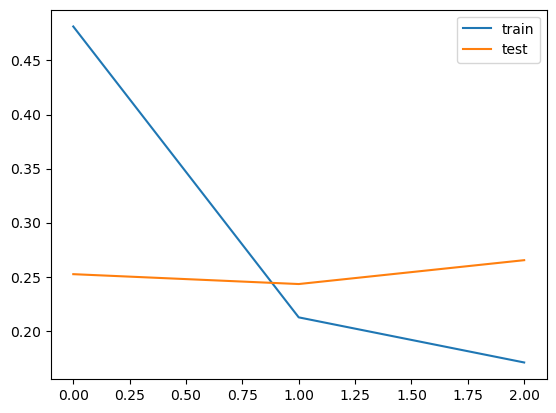

In [25]:
# plot training history

pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()